In [2]:
%load_ext autoreload
%autoreload 1

In [3]:
from scipy.stats import randint, uniform
from sklearn.model_selection import train_test_split
from src.data_loader import *
from src.training import *
from src.evaluation import *
from src.visualization import *
from sklearn.preprocessing import label_binarize
from PIL import Image
from IPython.display import Image, display

%aimport src.data_loader
%aimport src.visualization
%aimport src.training
%aimport src.evaluation

In [37]:
data = pd.read_csv("./data/synced_dataset.csv")
# data = remove_minority_class(data)
data[["item_id", "is_cnc", "multiclass_labels"]].head()

,item_id,is_cnc,multiclass_labels
0,100033,0,5
1,100034,0,11
2,100035,1,2
3,100036,1,2
4,100040,1,2


In [38]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62671 entries, 0 to 62670
Data columns (total 27 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   item_id             62671 non-null  int64  
 1   faces               62671 non-null  float64
 2   edges               62671 non-null  float64
 3   vertices            62671 non-null  float64
 4   file_name           62671 non-null  object 
 5   depth               62671 non-null  float64
 6   width               62671 non-null  float64
 7   height              62671 non-null  float64
 8   area                62671 non-null  float64
 9   volume              62671 non-null  float64
 10  bbox_depth          62671 non-null  float64
 11  bbox_height         62671 non-null  float64
 12  bbox_width          62671 non-null  float64
 13  bbox_area           62671 non-null  float64
 14  bbox_volume         62671 non-null  float64
 15  quantity            62671 non-null  int64  
 16  tech

In [20]:
features = [
    "faces", "edges", "vertices", "quantity",
    "height", "width", "depth", "volume", "area",
    "bbox_height", "bbox_width", "bbox_depth", "bbox_volume", "bbox_area",
]
X = data[features]


In [21]:
X_train, X_test, y_train_index, y_test_index = train_test_split(X, range(len(X)), test_size=0.2, random_state=42, stratify=data["multiclass_labels"])
y_multi_train = data["multiclass_labels"].iloc[y_train_index]
y_multi_test = data["multiclass_labels"].iloc[y_test_index]

y_binary_train = data["Is_CNC"].iloc[y_train_index]
y_binary_test = data["Is_CNC"].iloc[y_test_index]


params = {
    "n_estimators": randint(100, 300),
    "max_depth": randint(3, 10),
    "learning_rate": uniform(0.01, 0.3),
}

In [ ]:
best_search_multi = randomizedsearchcv_xgboost(X_train, y_multi_train, params)

In [25]:
# Save model to disk
joblib.dump(best_search_multi, "./models/best_model_multi.pkl")

['./models/best_model_multi.pkl']

In [ ]:
best_search_binary = randomizedsearchcv_xgboost(X_train, y_binary_train, params)

In [34]:
# Save model to disk
joblib.dump(best_search_binary, "./models/best_model_binary.pkl")

['./models/best_model_binary.pkl']

In [36]:
# Multiclass predictions
y_multi_pred = best_search_multi.best_estimator_.predict(X_test)
y_multi_prob = best_search_multi.best_estimator_.predict_proba(X_test)

# Binary predictions
y_binary_pred = best_search_binary.best_estimator_.predict(X_test)
y_binary_prob = best_search_binary.best_estimator_.predict_proba(X_test)

In [69]:
print("Multi-Class Model Evaluation")
metrics_multi = evaluate_classification(
    y_true=y_multi_test,
    y_pred=y_multi_pred,
    y_prob=y_multi_prob,
    top_k=3
)
pprint(metrics_multi)

print_classification_report(y_multi_test, y_multi_pred)

df_multi_class_accuracy = compute_per_class_accuracy(y_multi_test, y_multi_pred, le)
pprint(df_multi_class_accuracy)

Multi-Class Model Evaluation
{'accuracy': 0.7568639898428821,
 'f1_macro': 0.6574591818459546,
 'f1_weighted': 0.7593675642719472,
 'top_3_accuracy': 0.9148547849547691}
              precision    recall  f1-score   support

           0       0.82      0.88      0.85      1956
           1       0.89      0.83      0.86      5697
           2       0.80      0.75      0.78       552
           3       0.51      0.49      0.50       395
           4       0.68      0.58      0.63       132
           5       0.59      0.51      0.54      1480
           6       0.50      0.59      0.54       386
           7       0.62      0.67      0.65       199
           8       0.52      0.55      0.53       314
           9       0.49      0.72      0.58       815
          10       0.76      0.77      0.77       676

    accuracy                           0.76     12602
   macro avg       0.65      0.67      0.66     12602
weighted avg       0.77      0.76      0.76     12602

    Class  Accura

In [72]:
print("Binary Model Evaluation")
metrics_binary = evaluate_classification(
    y_true=y_binary_test,
    y_pred=y_binary_pred,
    y_prob=y_binary_prob,
)
pprint(metrics_binary)

print_classification_report(y_binary_test, y_binary_pred)

Binary Model Evaluation
{'accuracy': 0.8695445167433741,
 'average_precision': 0.9589503390498635,
 'f1_macro': 0.8584369100424147,
 'f1_weighted': 0.8704192801039596,
 'roc_auc': 0.935407056248672,
 'top_3_accuracy': None}
              precision    recall  f1-score   support

           0       0.79      0.84      0.82      4397
           1       0.91      0.88      0.90      8205

    accuracy                           0.87     12602
   macro avg       0.85      0.86      0.86     12602
weighted avg       0.87      0.87      0.87     12602



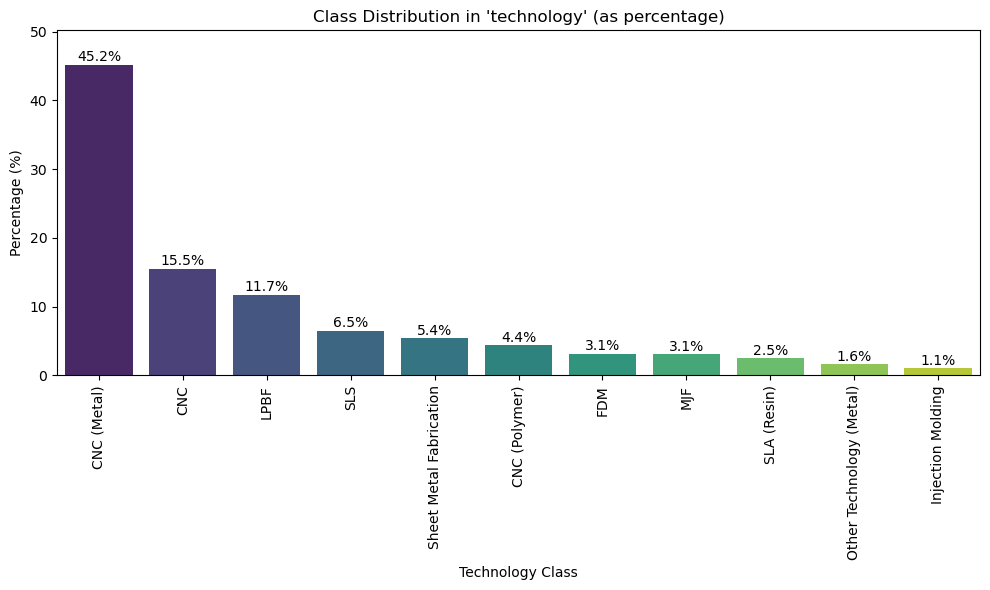

In [73]:
plot_class_distribution(data)

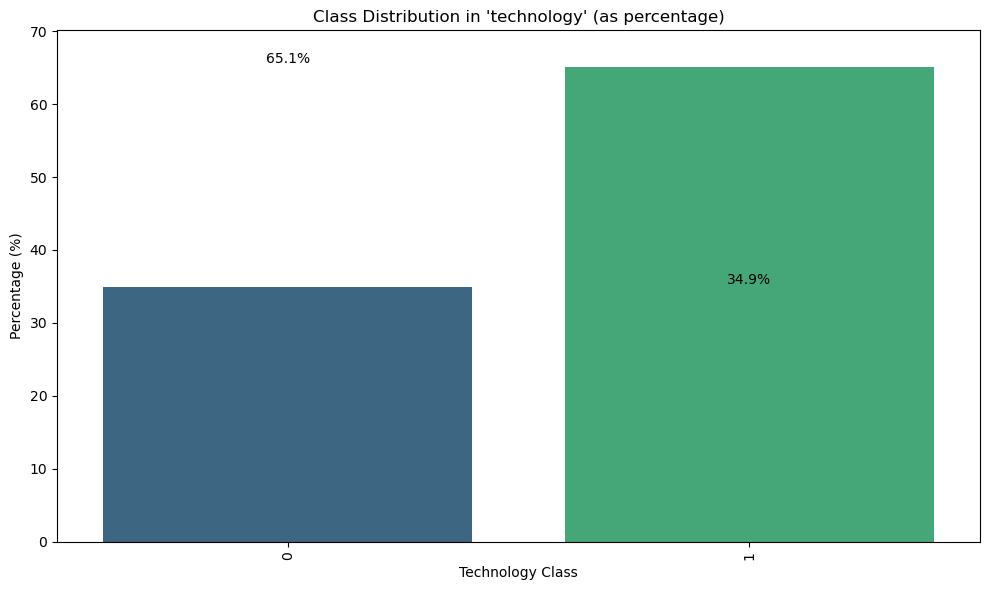

In [76]:
plot_class_distribution(data, target_col="Is_CNC")

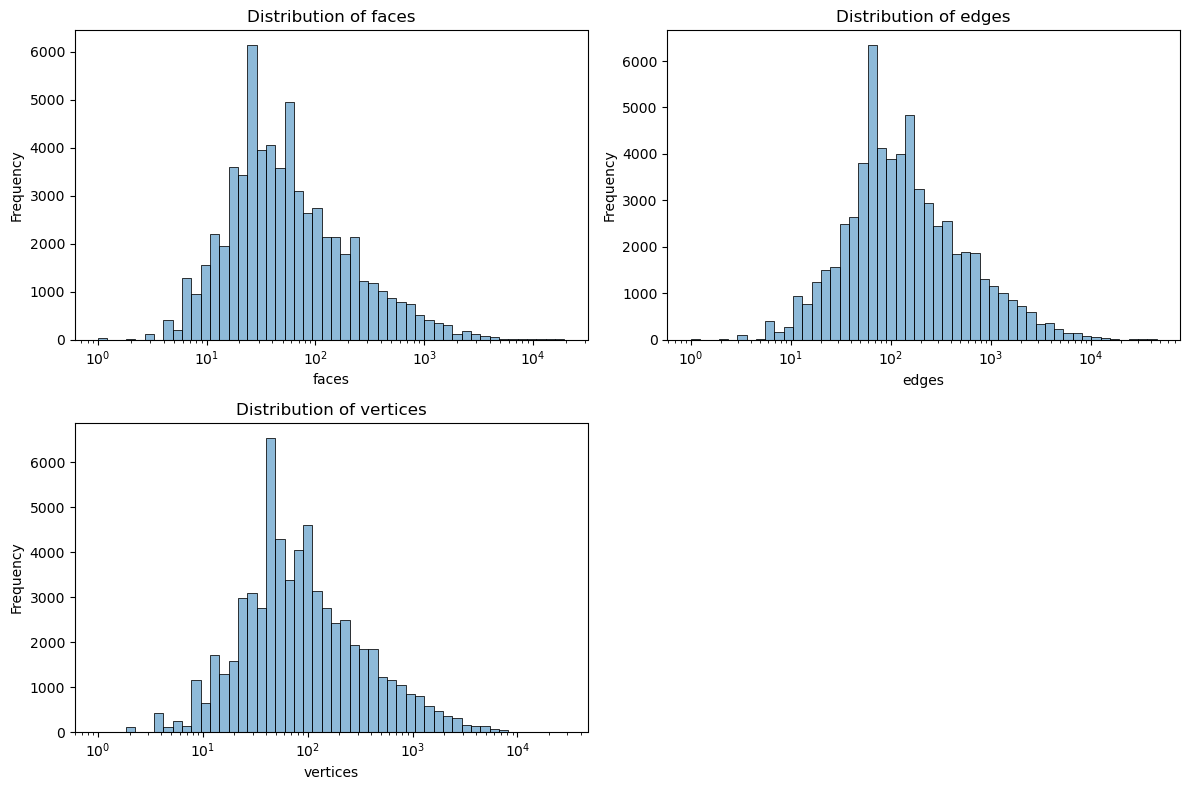

In [75]:
plot_topological_features_distribution(data, ["faces", "edges", "vertices"])

In [77]:
data.Is_CNC.value_counts()

Is_CNC
1    41019
0    21987
Name: count, dtype: int64

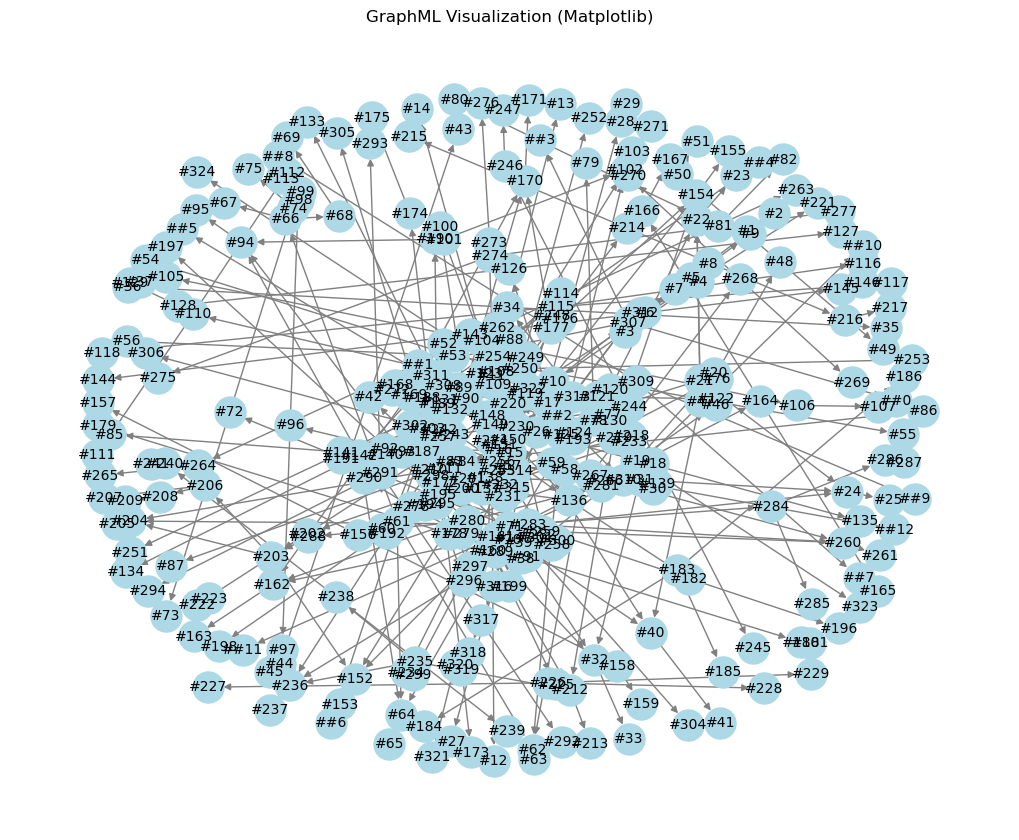

In [80]:
display_graphml_matplotlib(r"E:\step_files_graph\square_pocket.step.graphmlsquare_pocket.graphml")

In [9]:
G = nx.read_graphml(r"E:\step_files_graph\square_pocket.step.graphmlsquare_pocket.graphml")
print("Number of nodes:", G.number_of_nodes())
print("Number of edges:", G.number_of_edges())


Number of nodes: 337
Number of edges: 394


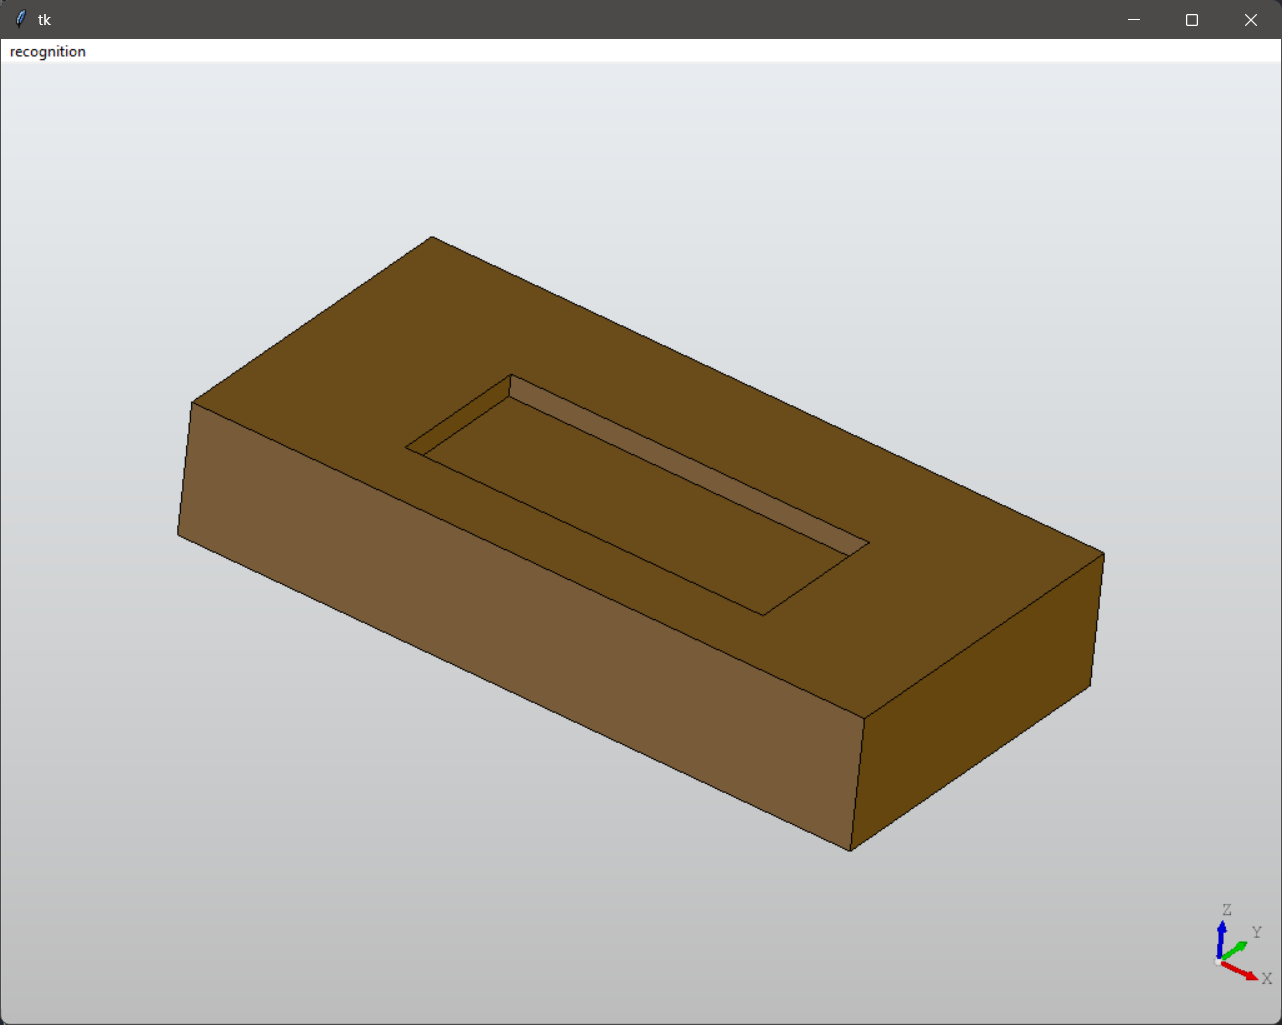

In [7]:
# display image from disk
display(Image(r"E:\2025-05-13.png"))

In [ ]:
G = nx.read_graphml(r"E:\step_files_test\square_pocket.step")
print("Number of nodes:", G.number_of_nodes())
print("Number of edges:", G.number_of_edges())

In [31]:
df_na = df.dropna()

<Axes: xlabel='multiclass_labels'>

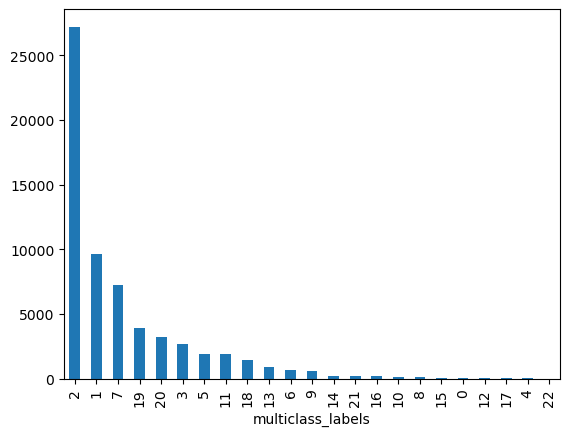